## Taichung DE forecast by LSTM

Data source :  TaiChung DE PV plant, CWB WUQI weather.

Time period : 2016/01/01-2017/12/31.

Time frequcy: 1 hour.

Try LSTM to forecast.

In [1]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

# Data processing

Visualizing data.

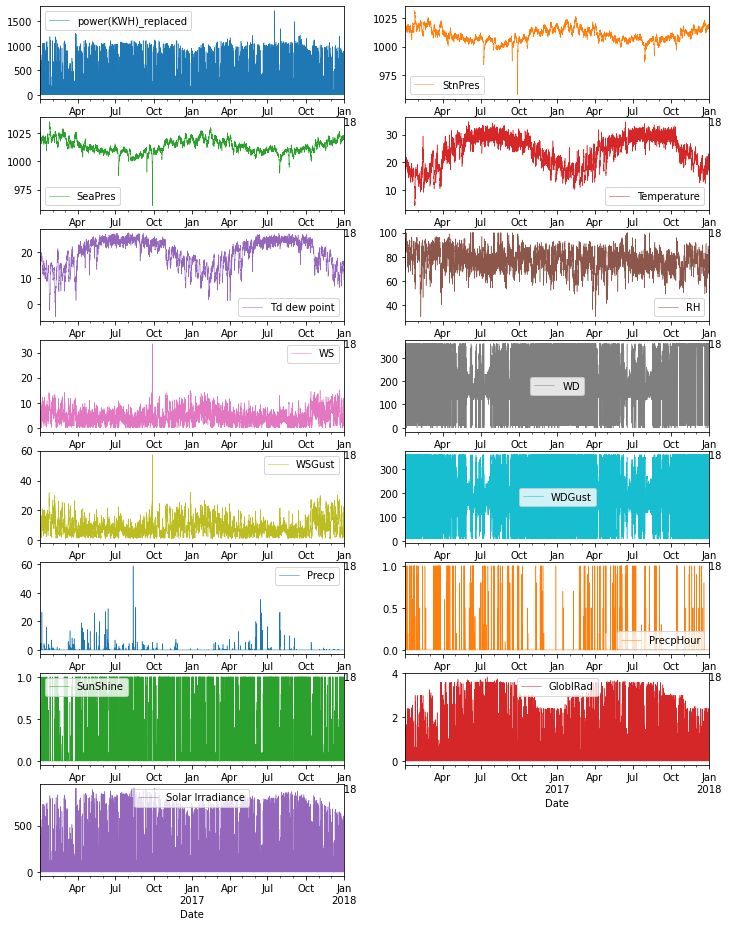

In [2]:
# quick look data
data = pd.read_csv('data\\Taichung_Power_Weather.csv', parse_dates=['Date'], index_col='Date')
# visualizing data
data.plot(subplots=True, linewidth=0.5, layout=(8, 2), figsize=(12, 16),
          sharex=False, sharey=False)
plt.show()

power(KWH)_replaced : PV plant produce energy ($KWH$).

StnPres : station pressure ($hPa$).

SeaPres :  sea surface pressure ($hPa$).

Temperature : temperature ($^{\circ}C$).

Td dew point : dew point temperature($^{\circ}C$).

RH : relative humidity ($\%$).
    
WS :  wind speed($m/s$).

WD :  wind direction ($^{\circ}$).

WSGust :   the maximum gust wind speed($m/s$).

WDGust :   the maximum gust wind direction ($^{\circ}$).

Precp : precipitation ($mm$).

PrecpHour : precipitation duration($Hour$).

SunShine : sunshine duration($Hour$).

GlobRad : global radiation($MJ/m^{2}$).

Solar Irradiance : solar irradiance ($KJ/m^{2}$)

Contain outlier, replace.

Let data in  $mean - 3 \times std < data < mean + 3 \times std $ .

Don't care night , choose day time .

In [3]:
# replace outlier
def replace_outlier(series):
    series_mean = series.mean()
    series_std = series.std()
    upper = series_mean + 3 * series_std 
    lower = series_mean - 3 * series_std
    series_new = np.where(series > upper, upper, np.where(series < lower, lower, series))
    return series_new
# choose day time
daytime_idx = ((6<= data.index.hour) & (data.index.hour<= 18))

for col in data.columns:
    data.loc[daytime_idx,col] = replace_outlier(data.loc[daytime_idx,col])

print(data[daytime_idx].describe().transpose())

                      count         mean         std         min         25%  \
power(KWH)_replaced  9503.0   386.390656  349.470772    0.000000    56.00000   
StnPres              9503.0  1010.017104    5.922215  991.783876  1005.90000   
SeaPres              9503.0  1013.114979    5.992838  994.676048  1009.00000   
Temperature          9503.0    24.368349    5.722668    7.162121    19.70000   
Td dew point         9503.0    19.659760    5.599656    2.742113    15.40000   
RH                   9503.0    75.614142    9.091097   47.962242    70.00000   
WS                   9503.0     5.052438    2.775342    0.000000     3.00000   
WD                   9503.0   255.102073  119.531531    0.000000   170.00000   
WSGust               9503.0    10.006392    5.374613    1.100000     6.00000   
WDGust               9503.0   220.930233  131.512571   10.000000   110.00000   
Precp                9503.0     0.107764    0.533163    0.000000     0.00000   
PrecpHour            9503.0     0.042590

Drop WS, WD, WDGust and WDGust because this is PV forecast.

Drop Precp and PrecpHour ,because 75% data are zero.

In [4]:
data_drop = data[daytime_idx].drop(columns=['WS', 'WD', 'WSGust', 'WDGust', 'Precp', 'PrecpHour'])

# Normalize

Norm min =0, max =1.

In [5]:
X_scale = MinMaxScaler(feature_range=(0, 1))
y_scale = MinMaxScaler(feature_range=(0, 1))
X_norm = X_scale.fit_transform(data_drop.iloc[:,1:])
y_norm = y_scale.fit_transform(data_drop.iloc[:,[0]])

In [6]:
data_scaled_X = pd.DataFrame(X_norm, index=data_drop.index, columns=data_drop.columns[1:])
data_scaled_y = pd.DataFrame(y_norm, index=data_drop.index, columns=[data_drop.columns[0]])
data_scaled = data_scaled_X.join(data_scaled_y)

# Create lag
Create time lag.

Choose target and feature.

In [7]:
# Creating time-lagged features
def create_lag(data, pasttime, futuretime):
    X, y = [], []
    for i in range(data.shape[0]-futuretime-pasttime):
        X.append(np.array(data.iloc[i:i+pasttime,:]))
        y.append(np.array(data.iloc[i+pasttime:i+pasttime+futuretime,-1]))
    return np.array(X), np.array(y)
Feature, Target = create_lag(data_scaled , 13, 1)
print(Feature.shape)

(9489, 13, 9)


Split train test datasets.

Choose last 4 month for validation.

In [8]:
# split train test data
X_train, X_test, y_train, y_test = train_test_split(Feature, Target, test_size=0.166,shuffle=False)

# Build model

Build LSTM model.

In [9]:
def build_Model(shape):

    model = Sequential()
    model.add(LSTM(52, input_shape=(shape[1],shape[2],), activation='relu', return_sequences=True))
    model.add(LSTM(26, activation='relu', return_sequences=False))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model

model = build_Model(X_train.shape)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 13, 52)            12896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 26)                8216      
_________________________________________________________________
dense (Dense)                (None, 1)                 27        
Total params: 21,139
Trainable params: 21,139
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
history = model.fit(X_train, y_train, epochs=1000, batch_size=128, verbose=2,  callbacks=[callback])

Epoch 1/1000
62/62 - 3s - loss: 0.0539
Epoch 2/1000
62/62 - 1s - loss: 0.0139
Epoch 3/1000
62/62 - 1s - loss: 0.0066
Epoch 4/1000
62/62 - 1s - loss: 0.0050
Epoch 5/1000
62/62 - 1s - loss: 0.0043
Epoch 6/1000
62/62 - 1s - loss: 0.0034
Epoch 7/1000
62/62 - 1s - loss: 0.0037
Epoch 8/1000
62/62 - 1s - loss: 0.0028
Epoch 9/1000
62/62 - 1s - loss: 0.0026
Epoch 10/1000
62/62 - 1s - loss: 0.0024
Epoch 11/1000
62/62 - 1s - loss: 0.0023
Epoch 12/1000
62/62 - 1s - loss: 0.0023
Epoch 13/1000
62/62 - 1s - loss: 0.0023
Epoch 14/1000
62/62 - 1s - loss: 0.0020
Epoch 15/1000
62/62 - 1s - loss: 0.0021
Epoch 16/1000
62/62 - 1s - loss: 0.0019
Epoch 17/1000
62/62 - 1s - loss: 0.0018
Epoch 18/1000
62/62 - 1s - loss: 0.0018
Epoch 19/1000
62/62 - 1s - loss: 0.0019
Epoch 20/1000
62/62 - 1s - loss: 0.0018
Epoch 21/1000
62/62 - 1s - loss: 0.0018
Epoch 22/1000
62/62 - 1s - loss: 0.0017
Epoch 23/1000
62/62 - 1s - loss: 0.0018
Epoch 24/1000
62/62 - 1s - loss: 0.0018
Epoch 25/1000
62/62 - 1s - loss: 0.0016
Epoch 26/

# Visualizing result.

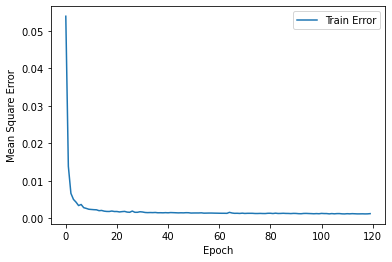

In [11]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['loss'],
             label='Train Error')
    plt.legend()

# The patience parameter is the amount of epochs to check for improvement

plot_history(history)


In [12]:
y_test_value = y_scale.inverse_transform(y_test.reshape(-1, 1))
y_predict_norm = model.predict(X_test)
y_predict = y_scale.inverse_transform(y_predict_norm)

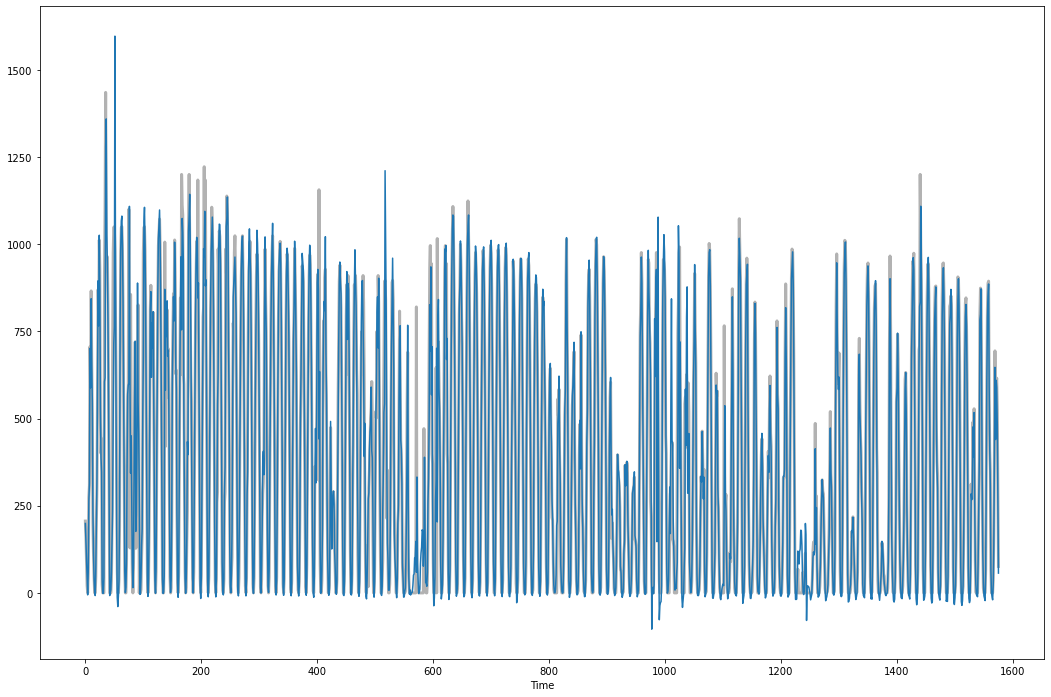

In [13]:
# visualizing predict
fig, ax = plt.subplots(figsize=(18,12))
ax.plot(y_test_value, color='k', alpha=.3, lw=3)
ax.plot(y_predict)
ax.set(xlabel="Time")
plt.show()

Model Score 

predict value : $ \hat{y}$  

actual value : $y$  

max of y : $y_{max}$

Mean squared error :

$$ \frac{1}{n} \sum_{k=1}^n ({y_{k} -\hat{y_{k}}})^2 $$

Mean absoluate error :

$$ \frac{1}{n} \sum_{k=1}^n \vert {y_{k} -\hat{y_{k}}} \vert $$

Mean relative error :

$$ \frac{100\%}{n} \sum_{k=1}^n \frac{{y_{k} -\hat{y_{k}}}}{y_{max}}  $$

Coefficient of determination :

$$ R^{2} \equiv 1 - \frac {SS_{res}}{SS_{tot}}$$

$$SS_{res} = \sum_{k=1}^n  { (\hat{y_{k}} - \tilde {y})^2}   ,SS_{tot} = \sum_{k=1}^n  { ({y_{k}} - \tilde {y})^2} 
, \tilde {y} = \frac{1}{n} \sum_{k=1}^n {y_{k}} $$

<!-- Mean absoluate percentage error :

% $$ \frac{100\%}{n} \sum_{k=1}^n \vert \frac{{y_{k} -\hat{y_{k}}}}{y_{k}} \vert $$ -->

In [14]:
def MRE(x,y):
    return np.nanmean(np.abs((x-y)/np.max(x)))

print('Mean squared error:{:.4f}'.format(mean_squared_error(y_test_value, y_predict)))
print('Mean absolute error:{:.4f}'.format(mean_absolute_error(y_test_value,y_predict)))
print('Mean relative error:{:.2%}'.format(MRE(y_test_value, y_predict)))
print('Coefficient of determination:{:.4f}'.format(r2_score(y_test_value, y_predict)))

Mean squared error:9123.4207
Mean absolute error:41.8004
Mean relative error:2.91%
Coefficient of determination:0.9265
